In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from nltk.util import ngrams
import networkx as nx  # pip install networkx if needed

# NLTK tokenizers
nltk.download("punkt")
nltk.download("punkt_tab")

# ---- Load fear lexicon ----
fear_lexicon_path = "/home/blitz/Desktop/NLP/Project/data/fear_lexicon.txt"

fear_lexicon = pd.read_csv(fear_lexicon_path, header=None, names=["word"])
fear_lexicon["word"] = fear_lexicon["word"].str.lower().str.strip()
fear_lexicon = fear_lexicon[fear_lexicon["word"] != ""].drop_duplicates()

fear_words = set(fear_lexicon["word"])
print(f"Loaded {len(fear_words)} fear-related entries.")


In [ ]:


pet_path = "/home/blitz/Desktop/NLP/Project/data/PetSemetary_updated.txt"
sh_path  = "/home/blitz/Desktop/NLP/Project/data/TheShining_updated.txt"

with open(pet_path, "r", encoding="utf-8") as f:
    pet_text = f.read()

with open(sh_path, "r", encoding="utf-8") as f:
    sh_text = f.read()

print("Raw text loaded.")
print("Pet Sematary length:", len(pet_text))
print("The Shining length:", len(sh_text))


def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s']", " ", text)  # keep letters, apostrophes, spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

pet_clean = clean_text(pet_text)
sh_clean  = clean_text(sh_text)

print("Cleaning complete.")


In [ ]:
# ---- Tokenize into word sequences ----
pet_tokens = word_tokenize(pet_clean)
sh_tokens  = word_tokenize(sh_clean)

print("Pet Sematary tokens:", len(pet_tokens))
print("The Shining tokens:", len(sh_tokens))



In [ ]:


BAD_TOKENS = {
    "'s", "s",
    "'m", "m",
    "'re", "re",
    "'ll", "ll",
    "'ve", "ve",
    "n't"
}

pet_tokens_clean = [t for t in pet_tokens if t.lower() not in BAD_TOKENS]
sh_tokens_clean  = [t for t in sh_tokens  if t.lower() not in BAD_TOKENS]

print("Original Pet tokens :", len(pet_tokens), "→ cleaned:", len(pet_tokens_clean))
print("Original Shining    :", len(sh_tokens), "→ cleaned:", len(sh_tokens_clean))



In [ ]:
def fear_ngrams(tokens, fear_set, n=2):
    """
    Return a Counter of n-grams (as strings) that contain
    at least one fear word.
    """
    counts = Counter()
    for gram in ngrams(tokens, n):
        gram_lower = tuple(w.lower() for w in gram)
        if any(w in fear_set for w in gram_lower):
            counts[" ".join(gram_lower)] += 1
    return counts

# 2-grams and 3-grams for each novel
pet_bi  = fear_ngrams(pet_tokens_clean, fear_words, n=2)
pet_tri = fear_ngrams(pet_tokens_clean, fear_words, n=3)

sh_bi   = fear_ngrams(sh_tokens_clean, fear_words, n=2)
sh_tri  = fear_ngrams(sh_tokens_clean, fear_words, n=3)

print("2-gram and 3-gram fear contexts extracted.")


In [ ]:
TOP_N = 15  # how many rows to show

def top_collocation_table(counter, title):
    top_items = counter.most_common(TOP_N)
    df = pd.DataFrame(top_items, columns=["n-gram", "count"])
    print("\n" + "="*70)
    print(title)
    print("="*70)
    display(df)
    return df

# ---- Pet Sematary ----
pet_bi_df  = top_collocation_table(pet_bi,  "Pet Sematary — Top 2-gram fear collocations")
pet_tri_df = top_collocation_table(pet_tri, "Pet Sematary — Top 3-gram fear collocations")

# ---- The Shining ----
sh_bi_df   = top_collocation_table(sh_bi,  "The Shining — Top 2-gram fear collocations")
sh_tri_df  = top_collocation_table(sh_tri, "The Shining — Top 3-gram fear collocations")


In [ ]:
def build_fear_cooc_graph(tokens, fear_set, window=5, min_weight=2):
    """
    Build an undirected graph:
    - nodes: fear words (from lexicon)
    - edge (w1, w2): they appear within `window` fear tokens of each other
    - weight: number of co-occurrences
    """
    # keep only tokens that are in the fear lexicon
    fear_seq = [w.lower() for w in tokens if w.lower() in fear_set]

    pair_counts = Counter()

    for i in range(len(fear_seq)):
        w1 = fear_seq[i]
        # look ahead within window
        for j in range(i + 1, min(i + window + 1, len(fear_seq))):
            w2 = fear_seq[j]
            if w1 == w2:
                continue
            edge = tuple(sorted((w1, w2)))
            pair_counts[edge] += 1

    G = nx.Graph()
    for (u, v), w in pair_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    return G

G_pet = build_fear_cooc_graph(pet_tokens, fear_words, window=5, min_weight=2)
G_sh  = build_fear_cooc_graph(sh_tokens,  fear_words, window=5, min_weight=2)

print("Pet Sematary graph:", G_pet.number_of_nodes(), "nodes,", G_pet.number_of_edges(), "edges")
print("The Shining graph:",  G_sh.number_of_nodes(),  "nodes,", G_sh.number_of_edges(),  "edges")


In [ ]:
def plot_fear_graph(G, title):
    plt.figure(figsize=(8, 8))

    # spring layout for clearer structure
    pos = nx.spring_layout(G, k=0.8, iterations=80, seed=42)

    node_size = 500  # fixed size

    if G.number_of_edges() > 0:
        weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
        edge_widths = 1 + (weights / weights.max()) * 2
    else:
        edge_widths = 1

    nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="#4B8BBE")
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_fear_graph(G_pet, "Fear Fear-Word Co-occurrence – Pet Sematary")
plot_fear_graph(G_sh,  "Fear Fear-Word Co-occurrence – The Shining")

In [ ]:


# fear_words (lexicon), pet_tokens, sh_tokens already exist

# Filter tokens that are in the fear lexicon
pet_fear_tokens = [w.lower() for w in pet_tokens if w.lower() in fear_words]
sh_fear_tokens  = [w.lower() for w in sh_tokens  if w.lower() in fear_words]

pet_fear_freq = pd.Series(pet_fear_tokens).value_counts()
sh_fear_freq  = pd.Series(sh_fear_tokens).value_counts()

TOP_N = 30

pet_top_words = set(pet_fear_freq.nlargest(TOP_N).index)
sh_top_words  = set(sh_fear_freq.nlargest(TOP_N).index)

print("Pet Sematary top fear words:", len(pet_top_words))
print("The Shining top fear words:", len(sh_top_words))


In [ ]:


def build_top_fear_graph(tokens, fear_set, top_words, window=5, min_weight=2):
    """
    Build graph where:
    - nodes: top fear words (intersection of fear_set and top_words)
    - edge: two top fear words appear within `window` fear tokens
    """
    # keep only fear tokens that are in top_words
    fear_seq = [w.lower() for w in tokens
                if (w.lower() in fear_set) and (w.lower() in top_words)]

    pair_counts = Counter()

    for i in range(len(fear_seq)):
        w1 = fear_seq[i]
        for j in range(i + 1, min(i + window + 1, len(fear_seq))):
            w2 = fear_seq[j]
            if w1 == w2:
                continue
            edge = tuple(sorted((w1, w2)))
            pair_counts[edge] += 1

    G = nx.Graph()
    for (u, v), w in pair_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    return G

G_pet_top = build_top_fear_graph(pet_tokens, fear_words, pet_top_words,
                                 window=5, min_weight=2)
G_sh_top  = build_top_fear_graph(sh_tokens,  fear_words, sh_top_words,
                                 window=5, min_weight=2)

print("Pet Sematary (top 30) :", G_pet_top.number_of_nodes(), "nodes,", G_pet_top.number_of_edges(), "edges")
print("The Shining (top 30)  :", G_sh_top.number_of_nodes(),  "nodes,", G_sh_top.number_of_edges(),  "edges")


In [35]:
from networkx.algorithms.community import greedy_modularity_communities

def plot_clustered_fear_graph(G, title):
    if G.number_of_nodes() == 0:
        print("Graph is empty:", title)
        return

    # --- community detection ---
    communities = list(greedy_modularity_communities(G))

    # map node -> community index
    comm_index = {}
    for i, comm in enumerate(communities):
        for node in comm:
            comm_index[node] = i

    # -----------------------------
    # NEW: fixed colors + theme labels
    # -----------------------------
    palette = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
    comm_to_color = {i: palette[i % len(palette)] for i in range(len(communities))}
    node_colors = [comm_to_color[comm_index[n]] for n in G.nodes()]

    def infer_theme(words):
        death = {"death","dead","dying","grave","kill","killed","corpse","burial","coffin","cemetery"}
        panic = {"fear","afraid","panic","terrified","scared","scream","screamed","screaming","terror"}
        psych = {"mad","insane","crazy","mind","dream","nightmare","hallucination","evil"}
        violence = {"blood","hurt","pain","knife","attack","violent","violence","wound","wounded"}

        scores = {
            "Death / Mortality": len(words & death),
            "Panic / Fear Response": len(words & panic),
            "Psychological Horror": len(words & psych),
            "Violence / Physical Harm": len(words & violence),
        }
        best = max(scores, key=scores.get)
        return best if scores[best] > 0 else "Mixed / General Fear"

    community_themes = {i: infer_theme(set(comm)) for i, comm in enumerate(communities)}
    # -----------------------------

    # node sizes by degree
    deg = dict(G.degree())
    node_sizes = [300 + deg[n] * 80 for n in G.nodes()]

    # edge widths by weight
    weights = np.array([G[u][v]["weight"] for u, v in G.edges()])
    edge_widths = 1 + (weights / weights.max()) * 2 if len(weights) else 1

    # layout
    pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42)

    plt.figure(figsize=(9, 9))
    nx.draw_networkx_edges(G, pos, alpha=0.35, width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    # NEW: add "Red = Death ..." legend
    handles, labels = [], []
    for i in range(len(communities)):
        c = comm_to_color[i]
        theme = community_themes[i]
        handles.append(plt.Line2D([0], [0], marker="o", linestyle="", markersize=10, color=c))
        labels.append(f"{c.capitalize()} = {theme}")

    plt.legend(handles, labels, loc="lower left", frameon=True, fontsize=9, title="Color → Theme")

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


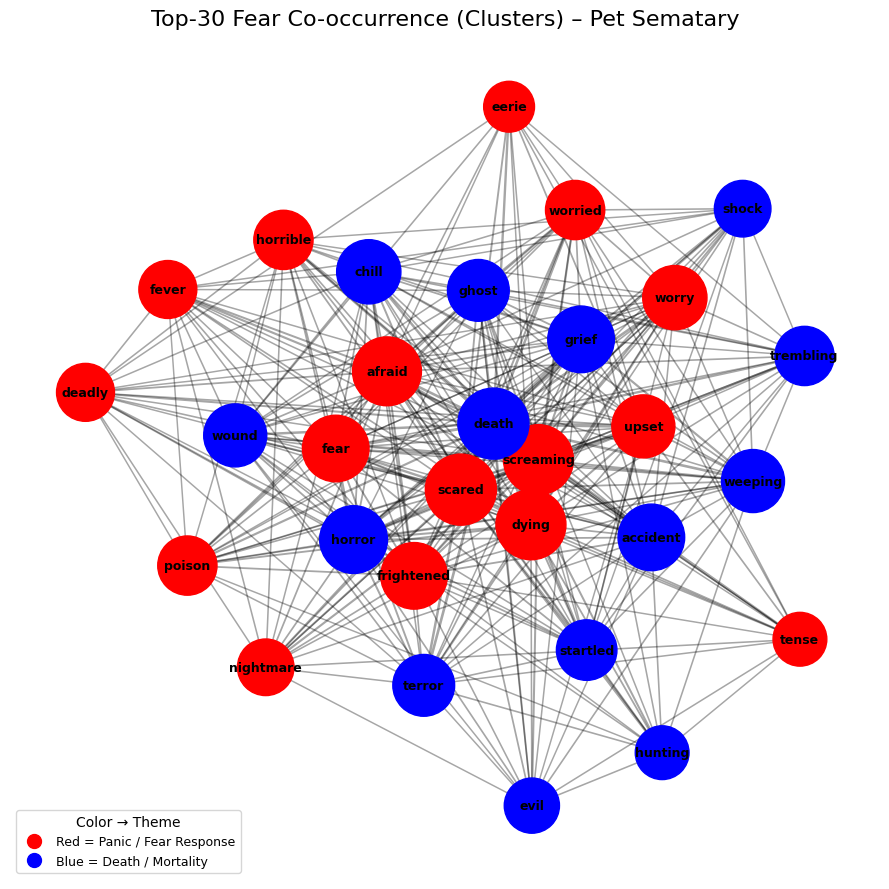

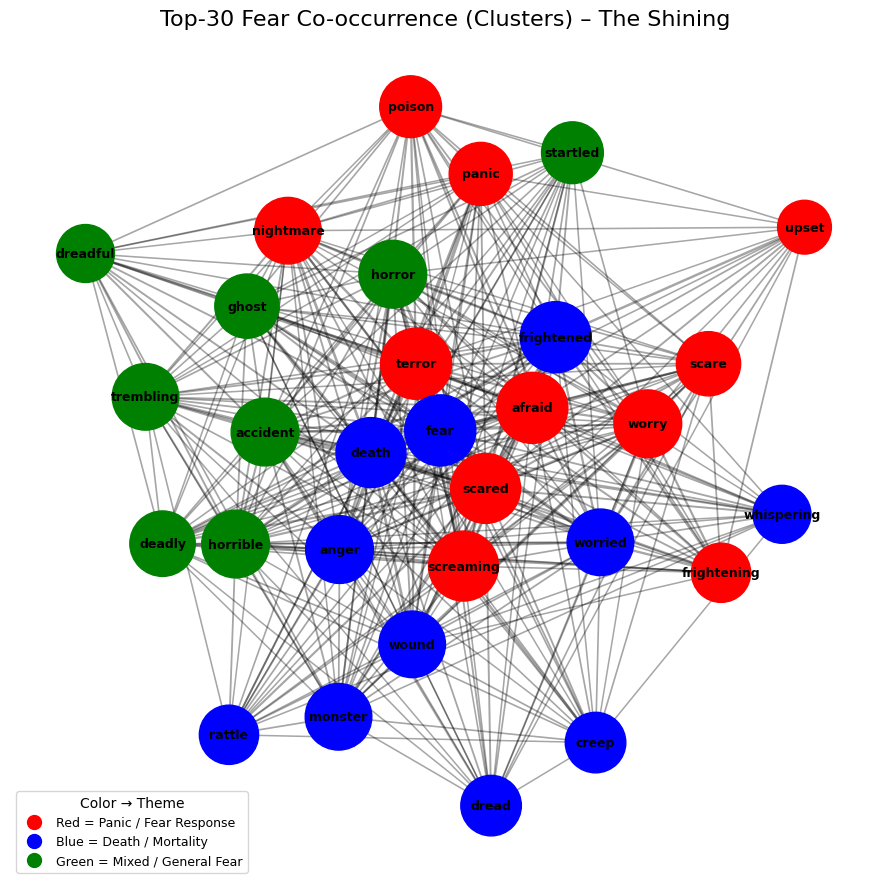

In [36]:


plot_clustered_fear_graph(G_pet_top, "Top-30 Fear Co-occurrence (Clusters) – Pet Sematary")
plot_clustered_fear_graph(G_sh_top,  "Top-30 Fear Co-occurrence (Clusters) – The Shining")
